## PySpark 安裝

In [ ]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxtst6
Suggested packages:
  libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 30.8 MB of archives.
After this operation, 104 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-8-jre-headless amd64 8u432-ga~us1-0ubuntu2~22.04 [30.8 MB]
Fetched 30.8 MB in 2s (17.4 MB/s)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3

## Google 評論數據集下載

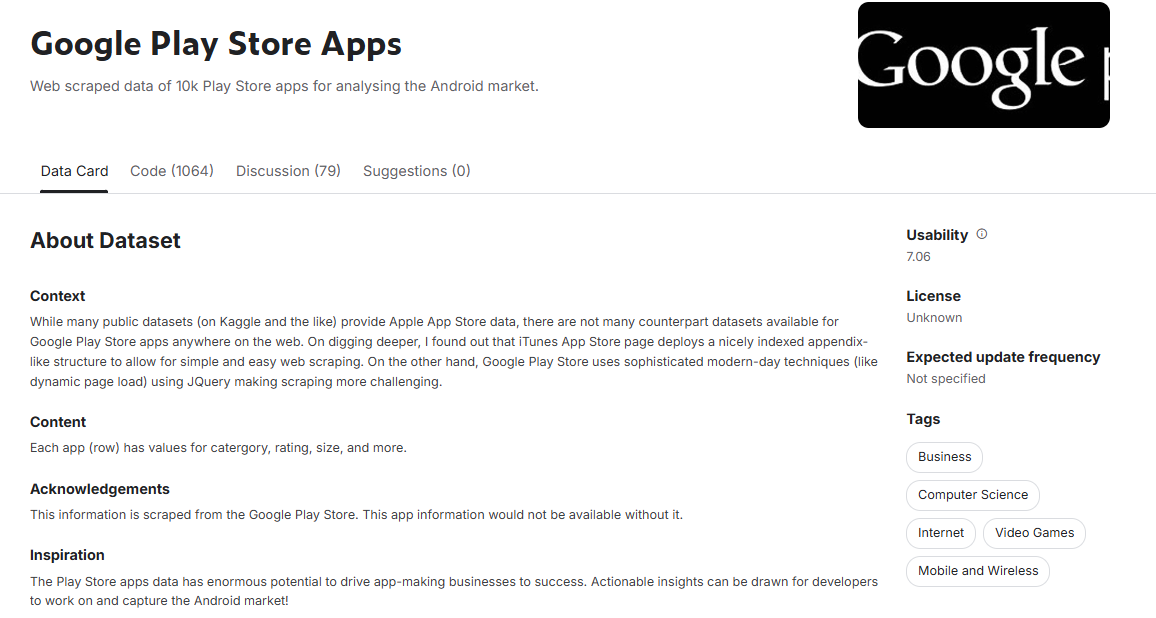

[Google Play Store Apps](https://www.kaggle.com/datasets/lava18/google-play-store-apps?select=googleplaystore_user_reviews.csv)

## 載入資料集

In [ ]:
from pyspark.sql import SparkSession

# 初始化 SparkSession
spark = SparkSession.builder \
    .appName("Google Play Reviews Analysis") \
    .getOrCreate()

# 加载数据
apps_df = spark.read.csv("apps.csv", header=True)
reviews_df = spark.read.csv("googleplaystore_user_reviews.csv", header=True, sep=",", multiLine=True, escape='"')


In [ ]:
reviews_df.select("Sentiment").distinct().show()


+---------+
|Sentiment|
+---------+
|      nan|
| Positive|
|  Neutral|
| Negative|
+---------+




## 查看數據欄位結構

In [ ]:
apps_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [ ]:

reviews_df.printSchema()


root
 |-- App: string (nullable = true)
 |-- Translated_Review: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- Sentiment_Polarity: string (nullable = true)
 |-- Sentiment_Subjectivity: string (nullable = true)



## 3. 數據清洗

刪除缺失值。

In [ ]:
apps_df = apps_df.dropna()
reviews_df = reviews_df.dropna()


資料型別轉換

轉換數值列的類型，例如 Installs 和 Price。

In [ ]:
from pyspark.sql.functions import regexp_replace, col

apps_df = apps_df.withColumn("Installs", regexp_replace(col("Installs"), "[+,]", "").cast("int"))
apps_df = apps_df.withColumn("Price", regexp_replace(col("Price"), "[$]", "").cast("float"))
apps_df = apps_df.withColumn("Reviews", col("Reviews").cast("int"))


刪除重複資料

In [ ]:
apps_df = apps_df.dropDuplicates()
reviews_df = reviews_df.dropDuplicates()


In [ ]:
from pyspark.sql.functions import col

# 將 Rating 轉換為數值類型
apps_df = apps_df.withColumn("Rating", col("Rating").cast("double"))

# 過濾掉轉換後為 null 的行（即非數值或空值）
apps_df = apps_df.filter(col("Rating").isNotNull())


## 4. 數據分析

### 任務 1: App 分類分佈

統計各類別的 App 數量。

In [ ]:
apps_df.groupBy("Category").count().orderBy("count", ascending=False).show()


+-------------------+-----+
|           Category|count|
+-------------------+-----+
|             FAMILY| 1511|
|               GAME|  832|
|              TOOLS|  625|
|    PERSONALIZATION|  274|
|          LIFESTYLE|  269|
|            MEDICAL|  266|
|            FINANCE|  258|
|       PRODUCTIVITY|  223|
|           BUSINESS|  222|
|             SPORTS|  221|
|        PHOTOGRAPHY|  204|
| HEALTH_AND_FITNESS|  190|
|      COMMUNICATION|  188|
|             SOCIAL|  156|
| NEWS_AND_MAGAZINES|  154|
|           SHOPPING|  146|
|   TRAVEL_AND_LOCAL|  141|
|BOOKS_AND_REFERENCE|  141|
|             DATING|  122|
|      VIDEO_PLAYERS|  112|
+-------------------+-----+
only showing top 20 rows



### 任務 2: 分數與安裝量的關係

+-------+------------------+-------------------+
|summary|            Rating|           Installs|
+-------+------------------+-------------------+
|  count|              7020|               7020|
|   mean| 4.160698005698019|   4472298.25042735|
| stddev|0.5592805938883545|2.715098662975042E7|
|    min|               1.0|                  1|
|    max|               5.0|         1000000000|
+-------+------------------+-------------------+



<Axes: xlabel='Rating', ylabel='Installs'>

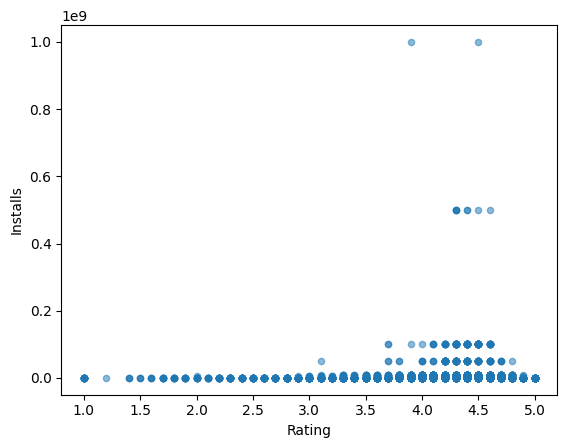

In [ ]:
apps_df.select("Rating", "Installs").describe().show()

# 視覺化
apps_df.select("Rating", "Installs").toPandas().plot.scatter(x="Rating", y="Installs", alpha=0.5)


### 任務 3: 評論情緒分佈

統計正面、中性、負面情緒的佔比。

In [ ]:
reviews_df.groupBy("Sentiment").count().show()


+---------+-----+
|Sentiment|count|
+---------+-----+
|      nan|  982|
| Positive|19015|
|  Neutral| 4356|
| Negative| 6321|
+---------+-----+



### 任務 4: 每個類別的平均評分

計算每個類別的平均評分並按評分排序。

In [ ]:
apps_df.groupBy("Category").avg("Rating").orderBy("avg(Rating)", ascending=False).show()


+-------------------+------------------+
|           Category|       avg(Rating)|
+-------------------+------------------+
|             EVENTS|4.4789473684210535|
|     ART_AND_DESIGN|  4.38103448275862|
|          EDUCATION| 4.373863636363637|
|          PARENTING| 4.347727272727271|
|    PERSONALIZATION|4.3244525547445285|
|BOOKS_AND_REFERENCE| 4.322695035460994|
|             BEAUTY|4.2918918918918925|
|             SOCIAL| 4.257692307692308|
|            WEATHER|             4.242|
|               GAME| 4.235697115384618|
|           SHOPPING|  4.21301369863014|
| LIBRARIES_AND_DEMO|             4.205|
|             SPORTS| 4.200904977375566|
| HEALTH_AND_FITNESS| 4.191052631578949|
|             FAMILY|4.1796161482461995|
|             COMICS| 4.168085106382979|
|            MEDICAL| 4.162406015037593|
|      ENTERTAINMENT| 4.154687499999999|
|  AUTO_AND_VEHICLES| 4.147619047619047|
| NEWS_AND_MAGAZINES| 4.143506493506495|
+-------------------+------------------+
only showing top

## 5. 進階分析

任務 5: 提取評論關鍵字

使用 PySpark 提取評論的常見關鍵字。

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import explode

# 分词
tokenizer = Tokenizer(inputCol="Translated_Review", outputCol="words")
reviews_df = tokenizer.transform(reviews_df)

# 移除停用词
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
reviews_df = remover.transform(reviews_df)

# 展开单词列并统计词频
word_counts = reviews_df.select(explode(col("filtered_words")).alias("word")).groupBy("word").count().orderBy("count", ascending=False)
word_counts.show(10)


+------+-----+
|  word|count|
+------+-----+
|  game| 4759|
|  like| 3988|
|  good| 3540|
|  love| 3466|
|   get| 3422|
| great| 3241|
|  time| 2494|
|really| 2270|
|  app.| 2133|
|  even| 2110|
+------+-----+
only showing top 10 rows



## 6. 保存分析结果

將結果儲存到 HDFS 或本地。

In [ ]:
# 將結果儲存到本地
apps_df.groupBy("Category").avg("Rating").write.csv("category_avg_ratings.csv", header=True)

# 儲存到 HDFS
#apps_df.write.csv("hdfs://<hdfs_path>/apps_data", header=True)

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/content/category_avg_ratings.csv already exists. Set mode as "overwrite" to overwrite the existing path.

## Spark Lab 1: 分析免費 App 的用戶評價分布


### Lab 目標
本 Lab 的目的是通過 Spark 分析免費 App 的用戶評價分布，並進一步探索評價數據中的情感傾向。此過程涵蓋數據清理、篩選和視覺化，幫助我們了解免費 App 的用戶評價情況。

### 1. 獲取 App 類型的獨特值

In [ ]:
apps_df.select("Type").distinct().show()


+----+
|Type|
+----+
|Free|
|Paid|
+----+



### 2. 篩選免費 App
篩選出 Type 為 "Free" 的 App。

In [ ]:
# 篩選免費的 App
free_apps_df = apps_df.filter(apps_df["Type"] == "Free")

# 檢查 Reviews 資料是否包含空值並清理
reviews_df = reviews_df.dropna(subset=["App", "Sentiment"])

### 3. 查看評價情感類別
檢視 Sentiment 欄位的所有獨特值。

In [ ]:
reviews_df.select("Sentiment").distinct().show()


+---------+
|Sentiment|
+---------+
|      nan|
| Positive|
|  Neutral|
| Negative|
+---------+



### 4. 合併 Apps 和 Reviews 表
將免費 App 資料與評價資料通過 "App" 欄位進行內部關聯。

In [ ]:
# Join apps 和 reviews 表
joined_df = free_apps_df.join(reviews_df, on="App", how="inner")

# 顯示關聯結果
joined_df.select("App", "Sentiment").show(10)


+--------------------+---------+
|                 App|Sentiment|
+--------------------+---------+
|3D Blue Glass Wat...|      nan|
|8fit Workouts & M...| Positive|
|A&E - Watch Full ...| Positive|
|           A+ Mobile|  Neutral|
|        ABCmouse.com| Negative|
|APE Weather ( Liv...| Negative|
|Abs Training-Burn...| Positive|
|Ada - Your Health...| Positive|
|Ada - Your Health...| Positive|
|   Add Text To Photo| Positive|
+--------------------+---------+
only showing top 10 rows



### 5.計算情感分布
計算各情感類別的數量分布，並顯示統計結果。

In [ ]:
sentiment_distribution = joined_df.groupBy('Sentiment').count()

# 顯示統計結果
sentiment_distribution.show()


+---------+-----+
|Sentiment|count|
+---------+-----+
|      nan|  646|
| Positive|12185|
|  Neutral| 2754|
| Negative| 4075|
+---------+-----+



### 6.視覺化結果

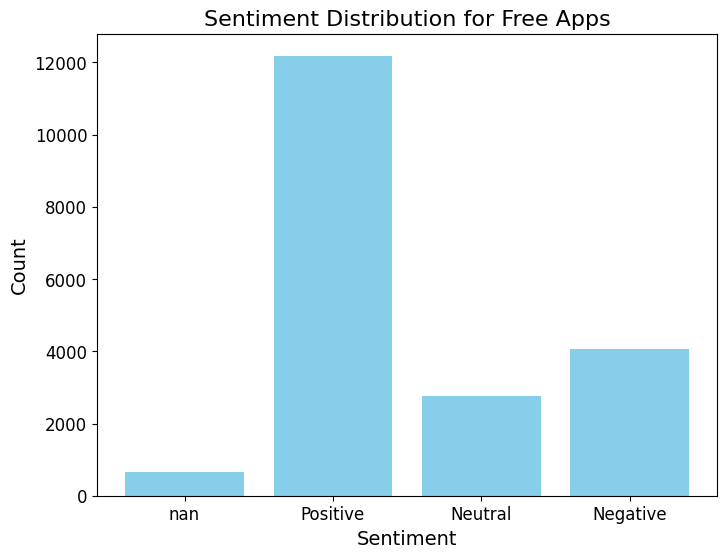

In [ ]:
import matplotlib.pyplot as plt

# 將結果轉換為 Pandas DataFrame
sentiment_pd = sentiment_distribution.toPandas()

# 繪製分佈圖
plt.figure(figsize=(8, 6))
plt.bar(sentiment_pd["Sentiment"], sentiment_pd["count"], color="skyblue")
plt.title("Sentiment Distribution for Free Apps", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Spark Lab 2: 分析收費 App 的用戶評價分布

In [ ]:
# 篩選收費的 App
Paid_apps_df = apps_df.filter(apps_df["Type"] == "Paid")

# 檢查 Reviews 數據是否含空值並清理
reviews_df = reviews_df.dropna(subset=["App", "Sentiment"])

In [ ]:
# Join apps 和 reviews 表
joined_df = Paid_apps_df.join(reviews_df, on="App", how="inner")

# 查看關聯後的結果
joined_df.select("App", "Sentiment").show(10)


+--------------------+---------+
|                 App|Sentiment|
+--------------------+---------+
|Diabetes & Diet T...| Positive|
|Diabetes & Diet T...| Positive|
|Diabetes & Diet T...| Positive|
|Dr. Panda & Toto'...| Positive|
| Essential Anatomy 3| Positive|
|Golfshot Plus: Go...| Positive|
| Essential Anatomy 3| Negative|
|Dr. Panda & Toto'...| Positive|
|Beautiful Widgets...| Positive|
|Diabetes & Diet T...| Positive|
+--------------------+---------+
only showing top 10 rows



In [ ]:
sentiment_distribution = joined_df.groupBy('Sentiment').count()

# 顯示統計結果
sentiment_distribution.show()


+---------+-----+
|Sentiment|count|
+---------+-----+
|      nan|   13|
| Positive|  229|
|  Neutral|   24|
| Negative|   50|
+---------+-----+



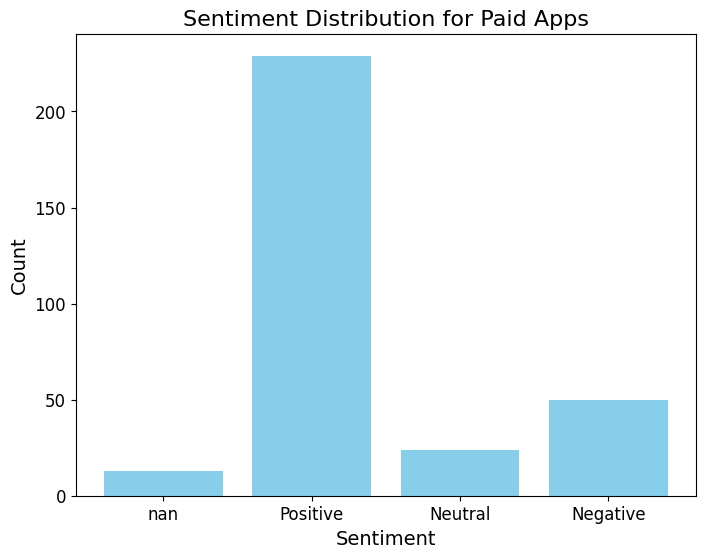

In [ ]:
import matplotlib.pyplot as plt

# 將結果轉換為 Pandas DataFrame
sentiment_pd = sentiment_distribution.toPandas()

# 繪製分佈圖
plt.figure(figsize=(8, 6))
plt.bar(sentiment_pd["Sentiment"], sentiment_pd["count"], color="skyblue")
plt.title("Sentiment Distribution for Paid Apps", fontsize=16)
plt.xlabel("Sentiment", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
